# Parameters

In [1]:
TRAIN_SIZE = 1200000
MIN_PATH_ROOT_SAMPLE = 15000
EPSILON = 0.000001
SESSION_THRESHOLD = 15 * 60 # seconds
TIME_WINDOW = 60 # seconds
DURATION_THRESHOLD = 180 * 60 # seconds


# Packages

In [214]:
#main packages
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from user_agents import parse

#scikit-learn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.feature_selection import mutual_info_classif

from datetime import datetime, timedelta

# Global helper functions

In [3]:
def get_root(s):
    if s.startswith('/') and len(s) > 1:
        s = s[1:]
    if len(s) > 1:
        s = s[:s.find('/')]
    return s

In [4]:
def get_path_roots(urls, min_samples_per_root=1000):
    t = [get_root(s) for s in urls]

    t = ['ROBOTS' if 'robots' in s else s for s in t]
    t = ['NUM' if s.isnumeric() else s for s in t]

    t2 = pd.Series(t).value_counts()[pd.Series(t).value_counts().values > min_samples_per_root]
    if 'ROBOTS' not in t2:
        roots = np.concatenate((t2.index.values, ['ROBOTS']))
        values = np.concatenate((t2.values, [pd.Series(t).value_counts()['ROBOTS']]))
    else:
        roots = np.array(t2.index.values)
        values = np.array(t2.values)
    return roots, values

In [5]:
def convert_urls_to_roots(urls, min_samples_per_root=1000):
    t = [get_root(s) for s in urls]

    t = ['ROBOTS' if 'robots' in s else s for s in t]
    t = ['NUM' if s.isnumeric() else s for s in t]

    t2 = pd.Series(t).value_counts()[pd.Series(t).value_counts().values > MIN_PATH_ROOT_SAMPLE]
    if 'ROBOTS' not in t2:
        roots = np.concatenate((t2.index.values, ['ROBOTS']))
    else:
        roots = np.array(t2.index.values)
    t = pd.Series([s if s in roots else 'OTHER' for s in t])
    return t

In [207]:
def get_categorical_status_code_counts(status_codes):
    status_counts = np.zeros(5)
    for i in range(status_codes.nunique()):
        status_counts[int(np.floor(int(status_codes.value_counts().index[i]) / 100) - 1)] += status_codes.value_counts().values[i]
    return status_counts

In [7]:
def isnumeric(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Dataset

In [8]:
df = pd.read_json('../result.json')

In [9]:
train = df

# Session Identification

## Helper functions

### Get Max Sustained Click Rate

In [11]:
def get_max_click_rate(session):
    m = 0
    session = session[session.url.apply(lambda x: 'pages' in x)]
    for l in session.datetime:
        m = max(m, len(session[(session.datetime >= l) &
                               (session.datetime <= l + timedelta(seconds=TIME_WINDOW))]))
    return m

In [13]:
get_max_click_rate(temp)

### Duration

In [208]:
def get_duration(session):
    return (Timestamp(session.datetime.iloc[-1]) - Timestamp(session.datetime.iloc[0])).seconds

In [ ]:
get_duration(temp)

### Percentage of Image Requests

In [13]:
def get_image_freq(session):
    t = [get_root(s) for s in session.url]
    return t.count('images') / len(t)

In [ ]:
get_image_freq(temp)

### Percentage of 4xx Error Responses 

In [186]:
def get_4xx_freq(session):
    status_counts = get_categorical_status_code_counts(session.status_code)
    return status_counts[3] / len(session)

In [115]:
get_4xx_freq(temp)

0.0

### Percentage of Page Requests

In [15]:
def get_page_freq(session):
    t = [get_root(s) for s in session.url]
    return (t.count('pages') + t.count('php') + t.count('asp')) / len(t)

In [161]:
get_page_freq(temp)

0.0

### Percentage of Head Requests

In [218]:
def get_head_freq(session):
    return len(session[session.http_method == 'Head']) / len(session)

In [174]:
get_head_freq(temp)

0.0

### Robots Request

In [17]:
def has_robots_req(session):
    t = ['robots' in s for s in session.url]
    return int(sum(t) > 0)

In [180]:
has_robots_req(temp)

0

### Is Bot

In [18]:
def is_bot(session):
    user_agent = parse(session.http_user_agent.iloc[0])
    return int(user_agent.is_bot)

In [198]:
is_bot(temp)

0

## Feature Extraction

In [19]:
train_gb = train.groupby(['http_user_agent', 'ip'])

In [20]:
res = pd.DataFrame(columns = ['session_ua', 'session_ip', 'head_freq', 'req_num', 'img_freq', 
                              'page_freq', 'status_4xx_freq', 'max_click_rate',
                              'has_robots', 'duration'])

for x, l in train_gb:
    temp = []
    for i in range(len(l)):
        if len(temp) > 0 and (l.datetime.iloc[i] - l.datetime.iloc[i-1]).seconds > SESSION_THRESHOLD:
            temp = pd.DataFrame(temp)
            res = res.append({'session_ua' : x[0], 
                              'session_ip' : x[1],
                              'head_freq' : get_head_freq(temp), 
                              'req_num' : len(temp),
                              'img_freq' : get_image_freq(temp),
                              'page_freq' : get_page_freq(temp),
                              'status_4xx_freq' : get_4xx_freq(temp),
                              'max_click_rate' : get_max_click_rate(temp),
                              'has_robots' : has_robots_req(temp),
                              'duration' : get_duration(temp),
                              'is_bot' : is_bot(temp)
                             }, 
                             ignore_index = True)
            temp = []
        temp.append(l.iloc[i])
    temp = pd.DataFrame(temp)
    res = res.append({'session_ua' : x[0], 
                      'session_ip' : x[1],
                      'head_freq' : get_head_freq(temp), 
                      'req_num' : len(temp),
                      'img_freq' : get_image_freq(temp),
                      'page_freq' : get_page_freq(temp),
                      'status_4xx_freq' : get_4xx_freq(temp),
                      'max_click_rate' : get_max_click_rate(temp),
                      'has_robots' : has_robots_req(temp),
                      'duration' : get_duration(temp),
                      'is_bot' : is_bot(temp)
                     }, 
                     ignore_index = True)
    

In [97]:
res.head()

,session_ua,session_ip,head_freq,req_num,img_freq,page_freq,status_4xx_freq,max_click_rate,has_robots,duration,is_bot,req_freq
0,AdsBot-Google (+http://www.google.com/adsbot.h...,207.213.134.109,0.0,17,0.000000,0.0,0.0,0,0,992,1.0,0.0171371
1,AdsBot-Google (+http://www.google.com/adsbot.h...,207.213.134.109,0.0,159,0.006289,0.0,0.0,0,0,6413,1.0,0.0247934
2,AdsBot-Google (+http://www.google.com/adsbot.h...,207.213.134.109,0.0,13,0.230769,0.0,0.0,0,0,9,1.0,1.44444
3,AdsBot-Google (+http://www.google.com/adsbot.h...,207.213.134.109,0.0,7,0.000000,0.0,0.0,0,0,910,1.0,0.00769231
4,AdsBot-Google (+http://www.google.com/adsbot.h...,207.213.134.109,0.0,9,0.333333,0.0,0.0,0,0,1080,1.0,0.00833333


In [206]:
df.datetime.iloc[0]

Timestamp('2021-05-12 05:06:00+0430', tz='pytz.FixedOffset(270)')

In [210]:
import json
import re


def parse_http_agent(http_agent):
    return http_agent


def req_parse(line: str):
    line = line.replace('[[', '[').replace(']]', ']')
    normal_dict_keys = ('ip', 'status_code', 'request_length', 'request_time',)
    in_bracket_dict_keys = ('datetime', 'method_and_url', 'http_user_agent')
    result_dict = dict()
    regex = r'(?<=\[).+?(?=\])'
    in_bracket_dict_values = re.findall(regex, line)
    for i in range(len(in_bracket_dict_keys)):
        result_dict[in_bracket_dict_keys[i]] = in_bracket_dict_values[i]
        line = line.replace(f' [{in_bracket_dict_values[i]}]', '')
    normal_dict_values = line.split()
    for i in range(len(normal_dict_keys)):
        result_dict[normal_dict_keys[i]] = normal_dict_values[i]

    result_dict['http_method'], result_dict['url'] = result_dict.pop('method_and_url').split()
    result_dict['http_user_agent'] = parse_http_agent(result_dict['http_user_agent'])
    return result_dict


In [188]:
def preprocess(session):
    res = pd.DataFrame(columns=['head_freq', 'req_num', 'img_freq',
                                'page_freq', 'status_4xx_freq', 'max_click_rate',
                                'has_robots', 'duration'])
    temp = []
    for i in range(len(session)):
        if len(temp) > 0 and (session.datetime.iloc[i] - session.datetime.iloc[i - 1]).seconds > SESSION_THRESHOLD:
            temp = pd.DataFrame(temp)
            res = res.append({'head_freq': get_head_freq(temp),
                              'req_num': len(temp),
                              'img_freq': get_image_freq(temp),
                              'page_freq': get_page_freq(temp),
                              'status_4xx_freq': get_4xx_freq(temp),
                              'max_click_rate': get_max_click_rate(temp),
                              'has_robots': has_robots_req(temp),
                              'duration': get_duration(temp),
                              'is_bot': is_bot(temp)
                              },
                             ignore_index=True)
            temp = []
        temp.append(session.iloc[i])
    temp = pd.DataFrame(temp)
    res = res.append({'head_freq': get_head_freq(temp),
                      'req_num': len(temp),
                      'img_freq': get_image_freq(temp),
                      'page_freq': get_page_freq(temp),
                      'status_4xx_freq': get_4xx_freq(temp),
                      'max_click_rate': get_max_click_rate(temp),
                      'has_robots': has_robots_req(temp),
                      'duration': get_duration(temp),
                      'is_bot': is_bot(temp)
                      },
                     ignore_index=True)
    return res.iloc[-1]

In [22]:
res = res[res.req_num >= 5]
res = res[res.duration > 0]
res['req_freq'] = res.req_num / res.duration

In [23]:
training_data = res.drop(columns=['session_ua', 'session_ip'])
training_data.head()

,head_freq,req_num,img_freq,page_freq,status_4xx_freq,max_click_rate,has_robots,duration,is_bot,req_freq
0,0.0,17,0.000000,0.0,0.0,0,0,992,1.0,0.0171371
1,0.0,159,0.006289,0.0,0.0,0,0,6413,1.0,0.0247934
2,0.0,13,0.230769,0.0,0.0,0,0,9,1.0,1.44444
3,0.0,7,0.000000,0.0,0.0,0,0,910,1.0,0.00769231
4,0.0,9,0.333333,0.0,0.0,0,0,1080,1.0,0.00833333


In [217]:
training_data.req_freq.max()

65.0

In [24]:
train_normalized = MinMaxScaler().fit_transform(training_data)
train_normalized = pd.DataFrame(train_normalized)
train_normalized.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.000508,0.000000,0.0,0.0,0.0,0.0,0.027392,1.0,0.000235
1,0.0,0.006520,0.006289,0.0,0.0,0.0,0.0,0.177235,1.0,0.000353
2,0.0,0.000339,0.230769,0.0,0.0,0.0,0.0,0.000221,1.0,0.022194
3,0.0,0.000085,0.000000,0.0,0.0,0.0,0.0,0.025126,1.0,0.000090
4,0.0,0.000169,0.333333,0.0,0.0,0.0,0.0,0.029825,1.0,0.000100


In [25]:
train_normalized = train_normalized.astype(np.float32)
train_normalized.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.000508,0.000000,0.0,0.0,0.0,0.0,0.027392,1.0,0.000235
1,0.0,0.006520,0.006289,0.0,0.0,0.0,0.0,0.177235,1.0,0.000353
2,0.0,0.000339,0.230769,0.0,0.0,0.0,0.0,0.000221,1.0,0.022194
3,0.0,0.000085,0.000000,0.0,0.0,0.0,0.0,0.025126,1.0,0.000090
4,0.0,0.000169,0.333333,0.0,0.0,0.0,0.0,0.029825,1.0,0.000100


## Aproximation Labeling (Session Mode)

In [26]:
x = res.iloc[5]
int(x.has_robots) + int(x.duration > DURATION_THRESHOLD) + int((x.page_freq / (x.img_freq + EPSILON)) >= 10)

0

In [27]:
def estimate_label(x):
    h = int(x.duration > DURATION_THRESHOLD) + int((x.page_freq / (x.img_freq + EPSILON)) >= 10)
    return int(x.is_bot or x.has_robots or h >= 2)

In [28]:
labels = res.apply(estimate_label, axis=1)
len(labels), sum(labels)

(32121, 690)

In [29]:
scores = np.load('scores.npy')

In [46]:
(scores[:,0] > 5.5).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [55]:
sum(labels & (scores[:,0] > 5.13).astype(int))

212

## Actual Label

In [95]:
def get_actual_label(x):
    return int('bot' in x.session_ua or 'Berry' in x.session_ua or 'Go-http-client' in x.session_ua or 'Python-urllib/3.7' in x.session_ua or 'python-requests/2.18.1' in x.session_ua)

actual_labels = res.apply(get_actual_label, axis=1)
len(actual_labels), sum(actual_labels)

(32121, 689)

## Evaluate Model

In [119]:
threshold = 5.1
preds = (scores[:,0] > threshold).astype(int)
print('precision:', sum(actual_labels & preds) / sum(preds))
print('recall:', sum(actual_labels & preds) / sum(actual_labels))
print('accuracy:', sum(actual_labels == preds) / len(actual_labels))

precision: 0.9033280507131537
recall: 0.8272859216255443
accuracy: 0.994396189408798


In [98]:
probably_anomalies = res[labels == 1]

In [99]:
labels = labels.reset_index(drop=True)
labels

0        1
1        1
2        1
3        1
4        1
        ..
32116    0
32117    0
32118    0
32119    0
32120    1
Length: 32121, dtype: int64

In [100]:
train_normalized['class'] = labels
train_normalized.head()

,0,1,2,3,4,5,6,7,8,9,class
0,0.0,0.000508,0.000000,0.0,0.0,0.0,0.0,0.027392,1.0,0.000235,1
1,0.0,0.006520,0.006289,0.0,0.0,0.0,0.0,0.177235,1.0,0.000353,1
2,0.0,0.000339,0.230769,0.0,0.0,0.0,0.0,0.000221,1.0,0.022194,1
3,0.0,0.000085,0.000000,0.0,0.0,0.0,0.0,0.025126,1.0,0.000090,1
4,0.0,0.000169,0.333333,0.0,0.0,0.0,0.0,0.029825,1.0,0.000100,1


In [103]:
train_normalized.to_csv('ds.csv', index=False)

In [104]:
res.corrwith(labels)

head_freq         -0.003939
img_freq           0.068172
page_freq          0.032962
status_4xx_freq   -0.013692
is_bot             0.102038
dtype: float64

## Variable Quantization

In [338]:
def get_threshold_for_quantization(feature_vector, labels):
    scale = (feature_vector.max() - feature_vector.min())
    m = 0
    threshold = -1
    for i in range(1,50):
        i = i/50
        i = i*scale + feature_vector.min()
        ig = mutual_info_classif((feature_vector > i).astype(int).values.reshape(-1, 1), 
                                 labels)
        if ig > m:
            m = ig
            threshold = i
    return threshold, m

In [339]:
t, m = get_threshold_for_quantization(res.req_num, labels)
print('req_num threshold:', t, ',information gain:', m)

t, m = get_threshold_for_quantization(res.img_freq, labels)
print('img_freq threshold:', t, ',information gain:', m)

t, m = get_threshold_for_quantization(res.page_freq, labels)
print('page_freq threshold:', t, ',information gain:', m)

t, m = get_threshold_for_quantization(res.max_click_rate, labels)
print('max_click_rate threshold:', t, ',information gain:', m)

t, m = get_threshold_for_quantization(res.duration, labels)
print('duration threshold:', t, ',information gain:', m)

t, m = get_threshold_for_quantization(res.req_freq, labels)
print('req_freq threshold:', t, ',information gain:', m)

req_num threshold: 0.0 ,information gain: [0.00172437]
img_freq threshold: 0.38 ,information gain: [0.02348947]
page_freq threshold: 0.32 ,information gain: [0.01210203]
max_click_rate threshold: 0.58 ,information gain: [0.01081792]
duration threshold: 0.0 ,information gain: [0.00164374]
req_freq threshold: 0.0 ,information gain: [0.00205998]


In [80]:
res.req_num = (res.req_num > 477.36).astype(int)
res.img_freq = (res.img_freq < 0.12).astype(int)
res.page_freq = (res.page_freq > 0.04).astype(int)
res.max_click_rate = (res.max_click_rate > 0.72).astype(int)
res.duration = (res.duration > 724.56).astype(int)
res.req_freq = (res.req_freq > 1.3).astype(int)

<BarContainer object of 2 artists>

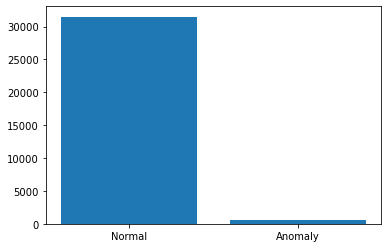

In [81]:
plt.bar(['Normal','Anomaly'], [sum(1-labels), sum(labels)])

In [346]:
X_train, X_test, y_train, y_test = train_test_split(res[['req_num', 'img_freq', 'page_freq', 'max_click_rate', 'duration', 'is_bot', 'req_freq']]
                                                    , labels)

In [364]:
X_train.shape, X_test.shape

((1000, 7), (8031, 7))

In [348]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB()
clf.fit(X_train, y_train)

BernoulliNB()

In [349]:
preds = clf.predict_proba(X_test)
preds = preds[:,1] >= 0.8
print("precision:", sum(preds & y_test) / sum(preds))
sum(preds), sum(preds == y_test) / len(y_test)

precision: 1.0


(133, 1.0)

In [350]:
X = res[['req_num', 'img_freq', 'page_freq', 'max_click_rate', 'duration', 'is_bot', 'req_freq']]

In [351]:
preds = clf.predict_proba(X)

In [352]:
true_preds_idx = np.argpartition(preds[:,1], -550)[-550:]
false_preds_idx = np.argpartition(preds[:,1], 550)[:550]

In [353]:
X = X.values[np.concatenate((true_preds_idx,false_preds_idx))]
y = clf.predict(X)
sum(y)

550

In [354]:
X_train, y_train, = train_test_split(X, test_size=5/55)
X_train.shape

(1000, 7)

In [355]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification

# clf = RandomForestClassifier(max_depth=4, random_state=0)
# clf.fit(X, y)

In [356]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X, y)

SVC(gamma='auto')

In [359]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, X, y, cv=10)
clf.fit(X, y)

DecisionTreeClassifier(random_state=0)

In [362]:
p = clf.predict(res[['req_num', 'img_freq', 'page_freq', 'max_click_rate', 'duration', 'is_bot', 'req_freq']])

In [363]:
from sklearn.metrics import accuracy_score

accuracy_score(labels, p)

1.0

# Preview data

In [51]:
train.head()

,datetime,http_user_agent,ip,status_code,request_length,request_time,http_method,url
0,2021-05-12 05:06:00+04:30,Googlebot-Image/1.0,207.213.193.143,304,0,32,Get,/cdn/profiles/1026106239
1,2021-05-12 05:06:00+04:30,Googlebot-Image/1.0,207.213.193.143,304,0,4,Get,images/badge.png
2,2021-05-12 05:06:00+04:30,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,35.110.222.153,200,52567,32,Get,/pages/630180847
3,2021-05-12 05:06:00+04:30,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,35.108.208.99,200,23531,20,Get,images/fav_icon2.ico
4,2021-05-12 05:06:00+04:30,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,35.110.222.153,200,4680,8,Get,images/sanjagh_logo_purpule5.png


In [52]:
train.describe()

,status_code
count,1.260035e+06
mean,2.313682e+02
std,5.804793e+01
min,1.010000e+02
25%,2.000000e+02
50%,2.000000e+02
75%,3.040000e+02
max,5.030000e+02


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260035 entries, 0 to 1260034
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype                                
---  ------           --------------    -----                                
 0   datetime         1260035 non-null  datetime64[ns, pytz.FixedOffset(270)]
 1   http_user_agent  1260035 non-null  object                               
 2   ip               1260035 non-null  object                               
 3   status_code      1260035 non-null  int64                                
 4   request_length   1260035 non-null  int64                                
 5   request_time     1260035 non-null  object                               
 6   http_method      1260035 non-null  object                               
 7   url              1260035 non-null  object                               
dtypes: datetime64[ns, pytz.FixedOffset(270)](1), int64(2), object(5)
memory usage: 76.9+ MB


# Visualize

In [14]:
train.head()

,datetime,http_user_agent,ip,status_code,request_length,request_time,http_method,url
0,2021-05-12 05:06:00+04:30,[Googlebot-Image/1.0],207.213.193.143,304,0,32,Get,/cdn/profiles/1026106239
1,2021-05-12 05:06:00+04:30,[Googlebot-Image/1.0],207.213.193.143,304,0,4,Get,images/badge.png
2,2021-05-12 05:06:00+04:30,"[[Linux, Android 6.0.1, SAMSUNG SM-J710GN Buil...",35.110.222.153,200,52567,32,Get,/pages/630180847
3,2021-05-12 05:06:00+04:30,"[[Linux, Android 6.0, CAM-L21], [KHTML, like G...",35.108.208.99,200,23531,20,Get,images/fav_icon2.ico
4,2021-05-12 05:06:00+04:30,"[[Linux, Android 6.0.1, SAMSUNG SM-J710GN Buil...",35.110.222.153,200,4680,8,Get,images/sanjagh_logo_purpule5.png


### IP : User Agent

In [15]:
print(len(train[train.ip == '-']))
train[train.ip == '-'].head()

18090


,datetime,http_user_agent,ip,status_code,request_length,request_time,http_method,url
25,2021-05-12 05:06:01+04:30,[kube-probe/1.21],-,301,169,-,Get,/
85,2021-05-12 05:06:03+04:30,[kube-probe/1.21],-,301,169,-,Get,/
145,2021-05-12 05:06:05+04:30,[kube-probe/1.21],-,301,169,-,Get,/
175,2021-05-12 05:06:07+04:30,[kube-probe/1.21],-,301,169,-,Get,/
215,2021-05-12 05:06:09+04:30,[kube-probe/1.21],-,301,169,-,Get,/


In [16]:
len(train[train.ip == '-'] == train[[s == ['kube-probe/1.21'] for s in train.http_user_agent]]) == len(train[train.ip == '-'])

True

### Status Code

In [17]:
train.status_code.value_counts()

200    765525
304    400543
101     61407
301     19725
307      7704
404      2004
499      1122
400       652
405       616
401       599
206        96
413        17
403        13
503         5
500         3
408         3
308         1
Name: status_code, dtype: int64

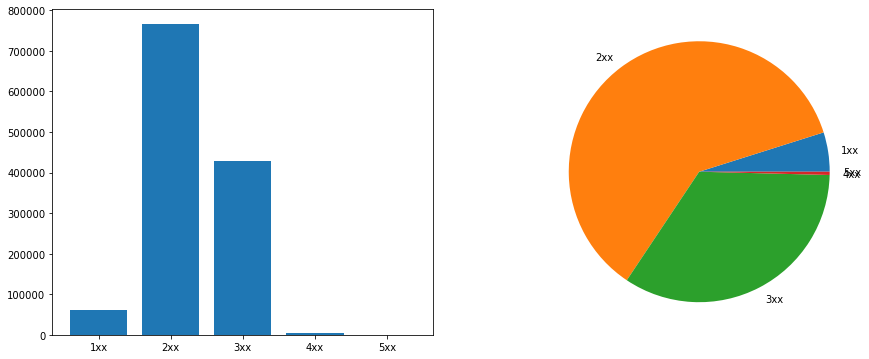

In [18]:
status_counts = get_categorical_status_code_counts(train.status_code)
status_labels = ['1xx','2xx','3xx','4xx','5xx']

f, axes = plt.subplots(1,2, figsize=(15,6))

axes[0].bar(status_labels, status_counts)
_ = axes[1].pie(status_counts, labels=status_labels)

### Request Lenght

In [19]:
train.request_length.describe()

count    1.260035e+06
mean     4.580962e+04
std      3.350437e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.201000e+03
75%      2.650500e+04
max      1.022335e+08
Name: request_length, dtype: float64

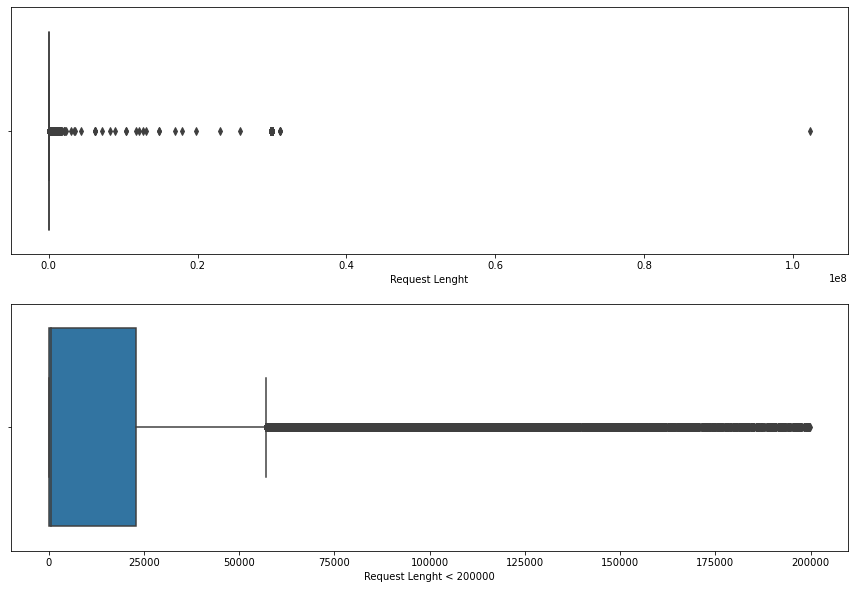

In [20]:
f, axes = plt.subplots(2, figsize=(15,10))
x = sns.boxplot(x=train.request_length, ax=axes[0])
limited_x = sns.boxplot(x=train.request_length[train.request_length < 200000], ax=axes[1])
x.set(xlabel='Request Lenght')
_ = limited_x.set(xlabel='Request Lenght < 200000')

### Request time

In [21]:
temp = train.copy().loc[train.request_time.apply(lambda x: not x.isnumeric())]
temp.head()

,datetime,http_user_agent,ip,status_code,request_length,request_time,http_method,url
25,2021-05-12 05:06:01+04:30,[kube-probe/1.21],-,301,169,-,Get,/
85,2021-05-12 05:06:03+04:30,[kube-probe/1.21],-,301,169,-,Get,/
145,2021-05-12 05:06:05+04:30,[kube-probe/1.21],-,301,169,-,Get,/
175,2021-05-12 05:06:07+04:30,[kube-probe/1.21],-,301,169,-,Get,/
215,2021-05-12 05:06:09+04:30,[kube-probe/1.21],-,301,169,-,Get,/


In [22]:
print(len(temp[temp.ip != '-']))
temp[temp.ip != '-'].head()

1718


,datetime,http_user_agent,ip,status_code,request_length,request_time,http_method,url
776,2021-05-12 05:06:31+04:30,"[[compatible, SemrushBot/7~bl, +http://www.sem...",20.62.177.11,200,53479,-,Get,/pros/1993352776
2010,2021-05-12 05:07:27+04:30,"[[compatible, SemrushBot/7~bl, +http://www.sem...",20.62.177.60,200,55330,-,Get,/pros/1797822247
2708,2021-05-12 05:08:04+04:30,"[[compatible, SemrushBot/7~bl, +http://www.sem...",20.62.177.133,200,20947,-,Get,/pros/763244865
2866,2021-05-12 05:08:18+04:30,"[[Linux, Android 6.0.1, Nexus 5X Build/MMB29P]...",207.213.193.118,301,169,-,Get,/pages/1939232229
3468,2021-05-12 05:08:49+04:30,"[[compatible, SemrushBot/7~bl, +http://www.sem...",20.62.177.4,200,37060,-,Get,/pros/2084824811


In [23]:
train_req_time = train.copy().loc[train.request_time.apply(lambda x: x.isnumeric())]
train_req_time.request_time = train_req_time.request_time.astype('int64')
train_req_time.shape, train.shape

((1240227, 8), (1260035, 8))

In [24]:
train_req_time.request_time.describe()

count    1.240227e+06
mean     6.819186e+03
std      1.845683e+05
min      0.000000e+00
25%      4.000000e+00
50%      1.200000e+01
75%      2.400000e+01
max      1.750470e+08
Name: request_time, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


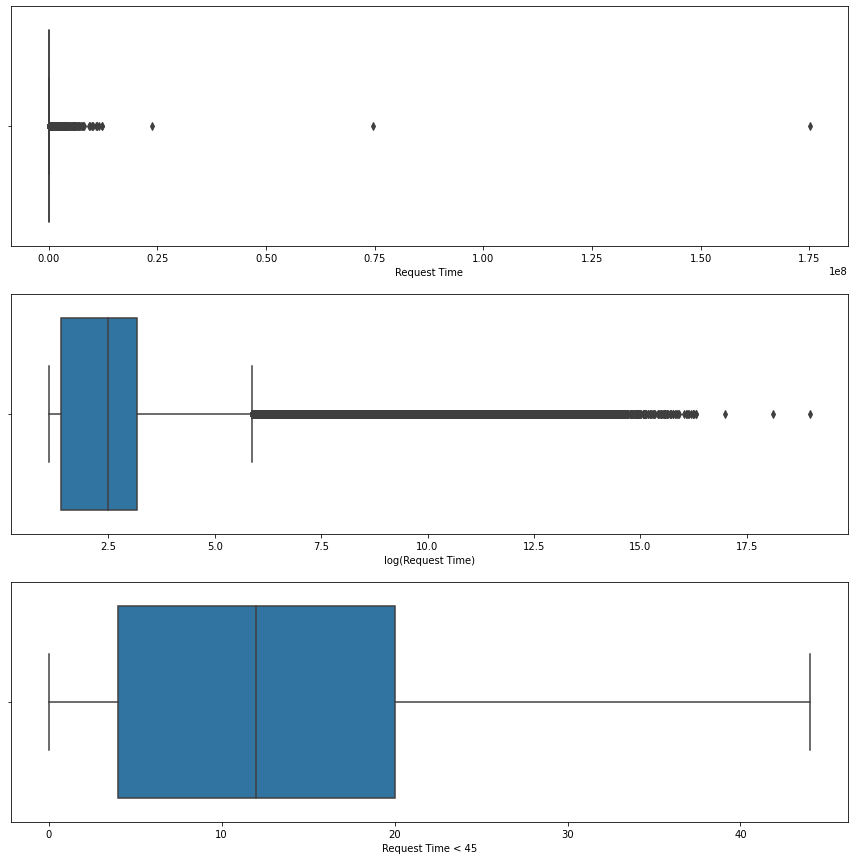

In [25]:
f, axes = plt.subplots(3, figsize=(15,15))

x = sns.boxplot(x=train_req_time.request_time, ax=axes[0])
log_x = sns.boxplot(x=np.log(train_req_time.request_time), ax=axes[1])
limited_x = sns.boxplot(x=train_req_time.request_time[train_req_time.request_time < 45], ax=axes[2])

x.set(xlabel='Request Time')
log_x.set(xlabel='log(Request Time)')
_ = limited_x.set(xlabel='Request Time < 45')

### Http Method

In [26]:
method_count = train.http_method.value_counts()
method_count.values

array([1141799,   65452,   32452,   20195,     137])

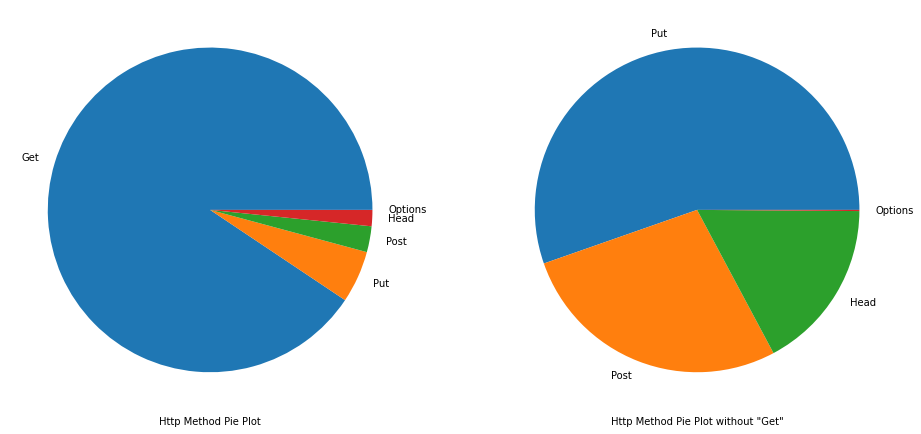

In [27]:
fig, axs = plt.subplots(1,2,figsize=(16,8))

axs[0].pie(train.http_method.value_counts().values, 
          labels=train.http_method.value_counts().index.values)
axs[1].pie(train.http_method[train.http_method != 'Get'].value_counts().values, 
          labels=train.http_method[train.http_method != 'Get'].value_counts().index.values)

axs[0].set(xlabel='Http Method Pie Plot')
_ = axs[1].set(xlabel='Http Method Pie Plot without "Get"')

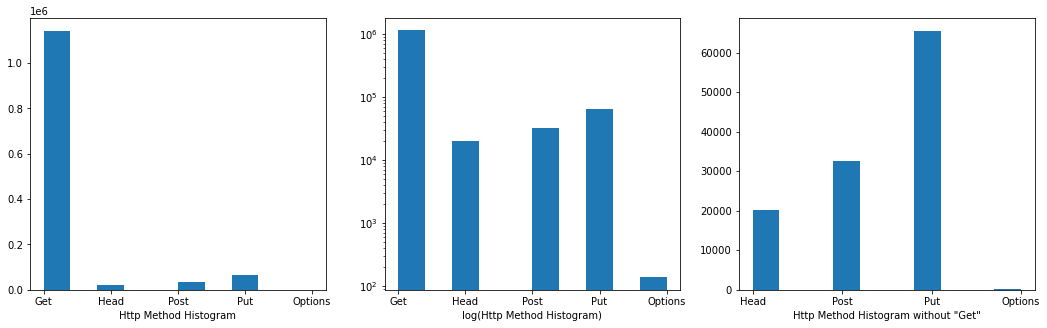

In [28]:
fig, axs = plt.subplots(1,3,figsize=(18,5))

axs[0].hist(train.http_method)
axs[1].hist(train.http_method, log=True)
axs[2].hist(train.http_method[train.http_method != 'Get'])

axs[0].set(xlabel='Http Method Histogram')
axs[1].set(xlabel='log(Http Method Histogram)')
_ = axs[2].set(xlabel='Http Method Histogram without "Get"')

### URL

In [96]:
roots, values = get_path_roots(train.url, MIN_PATH_ROOT_SAMPLE)

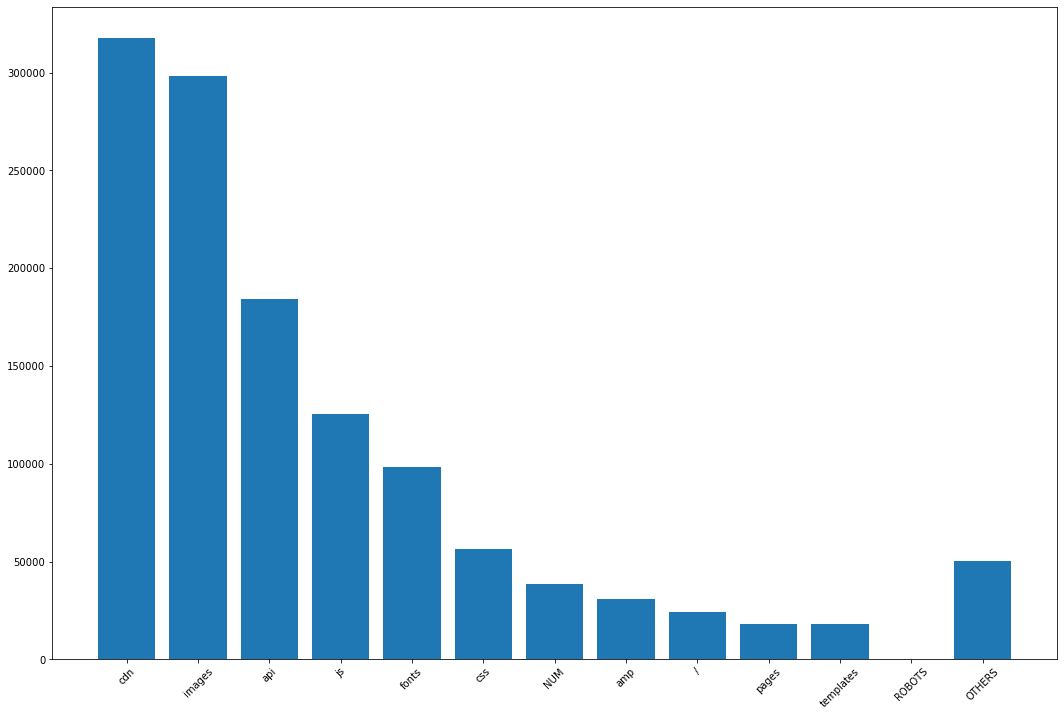

In [30]:
plt.figure(figsize=(18,12))
plt.bar(np.concatenate((roots, ['OTHERS'])), np.concatenate((values, [len(train.url) - sum(values)])))
_ = plt.xticks(rotation=45)

# Preprocess

### helper functions

In [11]:
def get_categorical_status_codes(status_codes):
    status_labels = ['1xx','2xx','3xx','4xx','5xx']
    return np.array([status_labels[np.floor(i / 100).astype(np.int64) - 1] for i in status_codes])

In [12]:
get_categorical_status_codes([201, 200,190, 545,333,412])

array(['2xx', '2xx', '1xx', '5xx', '3xx', '4xx'], dtype='<U3')

### cleaning

In [89]:
triain = train[train.ip == '-']

In [13]:
# request_time
train['null_req_time'] = np.array([0 if t.isnumeric() else 1 for t in train.request_time])
train.request_time = np.array([np.int64(t) if t.isnumeric() else 0 for t in train.request_time])

In [14]:
train.url.value_counts()

js/sentry.47b4061bac0b8ac89b9c.js      35992
/api/v2/token                          35655
fonts/IRANSansWeb_Light.woff2          34065
js/lazyload.797291581158393f5011.js    33328
/877499224                             33160
                                       ...  
/api/v2/connect/1539344641                 1
/cdn/pro_photo_gallery/1312908454          1
/api/v2/connect/294631614                  1
/api/v2/connect/359011110                  1
/cdn/taskPic/1169388351                    1
Name: url, Length: 138845, dtype: int64

In [15]:
# url
train.url = convert_urls_to_roots(train.url, MIN_PATH_ROOT_SAMPLE)

In [16]:
train.url.value_counts()

cdn          317724
images       298288
api          184213
js           125224
fonts         98485
css           56303
OTHER         50062
NUM           38394
amp           31085
/             24065
pages         18195
templates     17825
ROBOTS          172
Name: url, dtype: int64

In [17]:
train.status_code.nunique(), train.status_code.unique()

(17,
 array([304, 200, 301, 307, 101, 503, 500, 404, 405, 206, 499, 400, 401,
        413, 308, 403, 408]))

In [18]:
# status_code
train.status_code = get_categorical_status_codes(train.status_code)

In [19]:
train.status_code.nunique(), train.status_code.unique()

(5, array(['3xx', '2xx', '1xx', '5xx', '4xx'], dtype=object))

In [20]:
encoder = OneHotEncoder()
status_1hot = encoder.fit_transform(train[['status_code']])
method_1hot = encoder.fit_transform(train[['http_method']])
url_1hot = encoder.fit_transform(train[['url']])

train_cleaned = np.concatenate((
    train.drop(labels=['status_code','http_method','url'], axis=1), 
    status_1hot.toarray(), 
    method_1hot.toarray(),
    np.concatenate((url_1hot.toarray()[:,:2], url_1hot.toarray()[:,3:]), axis=1)), # OTHER -> column=2
    axis=1)

In [21]:
train_cleaned = pd.DataFrame(train_cleaned)
train_cleaned.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,2021-05-12 05:06:00+04:30,[Googlebot-Image/1.0],207.213.193.143,0,32,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,2021-05-12 05:06:00+04:30,[Googlebot-Image/1.0],207.213.193.143,0,4,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,2021-05-12 05:06:00+04:30,"[[Linux, Android 6.0.1, SAMSUNG SM-J710GN Buil...",35.110.222.153,52567,32,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2021-05-12 05:06:00+04:30,"[[Linux, Android 6.0, CAM-L21], [KHTML, like G...",35.108.208.99,23531,20,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2021-05-12 05:06:00+04:30,"[[Linux, Android 6.0.1, SAMSUNG SM-J710GN Buil...",35.110.222.153,4680,8,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [22]:
train_cleaned.drop(columns=[0,1,2], inplace=True)

In [23]:
# min_max scalar
train_normalized = MinMaxScaler().fit_transform(train_cleaned)
train_normalized = pd.DataFrame(train_normalized)
train_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.000000,1.828080e-07,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,2.285100e-08,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.000514,1.828080e-07,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000230,1.142550e-07,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000046,4.570200e-08,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Approximate Labeling

In [24]:
# s = str(pd.Series([str(s) for s in df.http_user_agent]).unique())
# with open("unique.txt", "w") as text_file:
#     print(f"Unique : {s}", file=text_file)

### for Base Model

In [25]:
def is_anomaly(s):
    if ('bot' in str(s).lower() or 'go-http-client' in str(s).lower()) and not 'google' in str(s).lower() and not 'apple' in str(s).lower() and not 'android' in str(s).lower():
        return True
    return False

In [26]:
def get_approximate_labels(data):
    labels = [int(is_anomaly(s)) for s in data.http_user_agent]
    return np.array(labels)

In [27]:
def evaluate(pred):
    y = get_approximate_labels(train)
    print("Precision : %", sum(pred & y) / sum(y) * 100)

In [28]:
sum(get_approximate_labels(train))

66416

### for Session Based Model

In [ ]:
def estimate_label(session):
    

# Models

In [29]:
from pycaret.anomaly import *
exp_name = setup(data = train_normalized)

,Description,Value
0,session_id,2920
1,Original Data,"(1260035, 25)"
2,Missing Values,False
3,Numeric Features,2
4,Categorical Features,23
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(1260035, 48)"
9,CPU Jobs,-1


### Cluster based model

In [30]:
cluster_based_model = create_model('cluster')

In [31]:
cluster_results = assign_model(cluster_based_model)
cluster_results.Anomaly.sum()

62829

In [32]:
evaluate(cluster_results.Anomaly)

Precision : % 0.8341363526860996


### PCA based model

In [33]:
pca_based_model = create_model('pca')

In [34]:
pca_results = assign_model(pca_based_model)
pca_results.Anomaly.sum()

63001

In [35]:
evaluate(pca_results.Anomaly)

Precision : % 57.57498193206456


### ROC Curve

In [41]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

Best Threshold=957370922687284224.000000, G-Mean=0.856


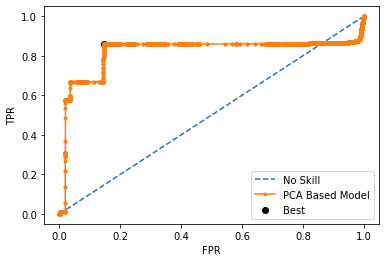

In [87]:
fpr, tpr, thresholds = roc_curve(get_approximate_labels(train), pca_results.Anomaly_Score)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='PCA Based Model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.show()

### Precision Recall Curve

Best Threshold=1382801314979517184.000000, F-Score=0.597
Recall=0.575720, Precision=0.596637


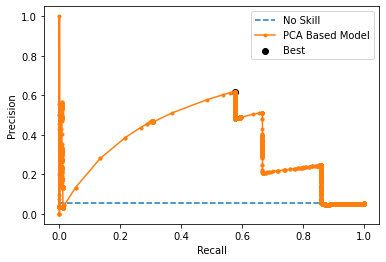

In [84]:
from sklearn.metrics import precision_recall_curve

testy = get_approximate_labels(train)
precision, recall, thresholds = precision_recall_curve(testy, pca_results.Anomaly_Score)

fscore = (2 * precision * recall) / (precision + recall)
fscore = np.nan_to_num(fscore)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('Recall=%f, Precision=%f' % (recall[ix], fscore[ix]))

no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='PCA Based Model')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()